# Прогнозирование оттока клиентов из банка

**Описание проекта:**
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для анализа предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель:**
на основе имеющихся данных, построить модель, которая будет прогнозировать вероятность того, уйдет ли клиент из банка в ближайшее время.

**Описание данных:**
Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

**План работы:**
- Загрузить и подготовить данные.
- Исследовать баланс классов, обучить модель без учёта дисбаланса.
- Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.
- Провести финальное тестирование.

## Исходные данные

### Первый взгляд

In [1]:
!pip install imblearn

     |████████████████████████████████| 225 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 69.7 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import warnings


warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


C типами данных все хорошо, можно не менять. Теперь посмотрим на пропуски и дубликаты. Сразу переведем названия колонок в нижний регистр.

In [4]:
df.columns = df.columns.str.lower()
# df.head() #проверка

In [5]:
print(df.isna().sum())
print('\n\nduplicates:', df.duplicated().sum())

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64


duplicates: 0


Присутствует около 10% пропусков в колонке tenure. Не будем удалять - многовато, да и колонка кажется важной.
Полных дубликатов нет.

Есть колонки которые точно не понадобятся, их можно целиком дропнуть. Это: rawnumber (индекс итак ведь есть) и surname (будем верить, что надежность клиента не зависит от его фамилии). Customerid вцелом тоже не нужен для обучения модели, но потом возможно будет нужен для сотрудников банка, чтобы опознать неблагонадежных клиентов, при желании его можно будет обратно приклеить в тестовой выборке.

In [6]:
df = df.drop(['rownumber', 'customerid', 'surname'], axis='columns')
#df.columns  #проверка

Посмотрим какие значения у нас лежат в датасете в численных столбцах.

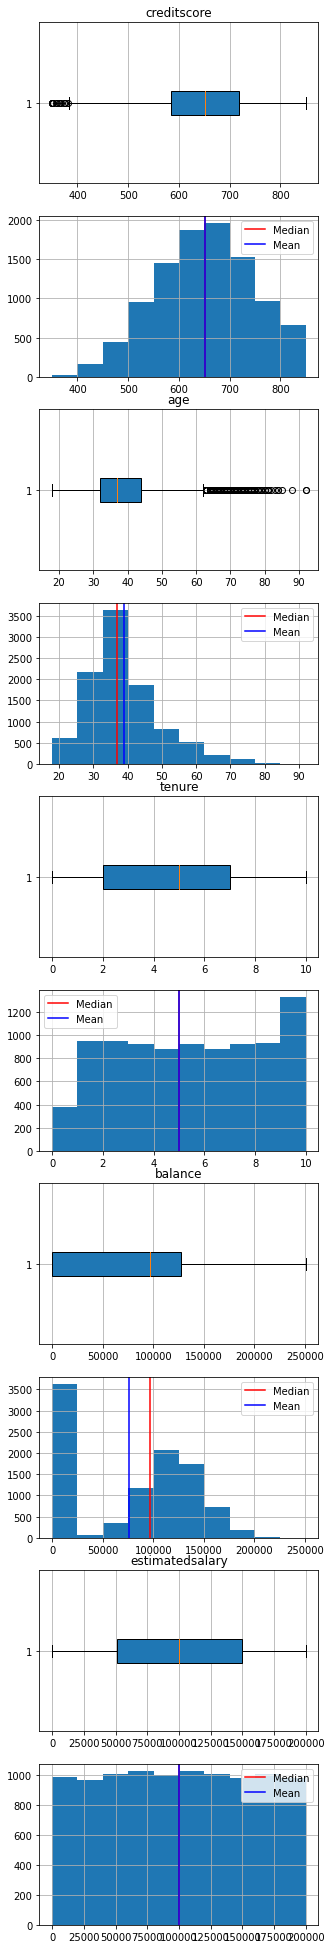

In [7]:
columns_var = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']
n = 1
plt.figure(figsize=(5, 35))
for col in columns_var:
    plt.subplot(10,1,n)
    plt.boxplot(df[df[col].notna()][col], vert=False, patch_artist=True)
    plt.title(col)
    plt.grid()
    n += 1
    plt.subplot(10,1,n)
    plt.hist(df[col])
    plt.axvline(x=df[col].median(), color='r', label='Median')
    plt.axvline(x=df[col].mean(), color='b', label='Mean')
    plt.legend()
    plt.grid()
    n += 1
plt.show()

Никаких страшных аномалий не видно.

Посмотрим теперь, какие значения в категориальных столбцах.

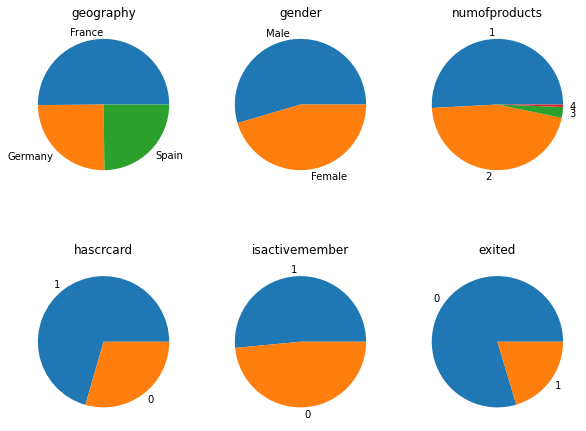

In [8]:
columns_cat = ['geography', 'gender', 'numofproducts', 'hascrcard', 'isactivemember', 'exited']
n = 1
plt.figure(figsize=(10,8))
for col in columns_cat:
    plt.subplot(2,3,n)
    n += 1
    y = df[col].value_counts()
    plt.pie(y, labels=y.index)#, colors=plt.cm.Dark2.colors)
    plt.title(col)
   # plt.show()
 #   print(df[col].value_counts())

Проверим нет ли мультиколлинеарности.

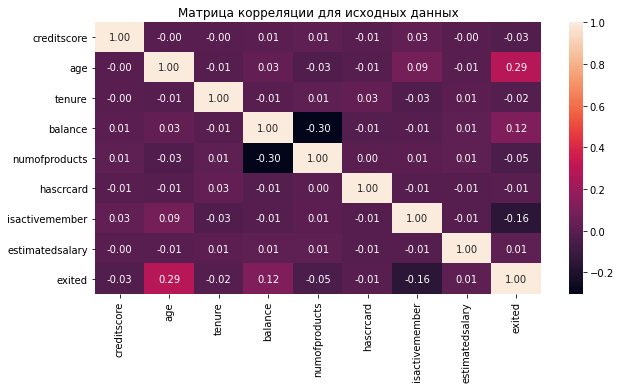

In [9]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.title('Матрица корреляции для исходных данных')
plt.show()

**Вывод**

Явных дубликатов нет, пропуски есть только в столбце tenure (около 10%), мультиколлинеарности данных тоже нет. Наибольший коэф. корреляции Пирсона с целевым признаком, у столбца age.


### Заполнение пропусков

Посмотрим на строки с пропущенными значениями

In [10]:
df[df['tenure'].isna()].head(10)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Ничего подозрительного. Заполним пропуски медианой.

In [11]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median())
# df.isna().sum() #проверка

## Подготовка признаков

### Разбивка на тренировочную и тестовую выборки

Прежде всего разбиваем датасет на тренировочный с тестовым. Валидационный делать не будем, валидацию пусть гридсерч сам вытаскивает из трейна.

In [12]:
features = df.drop('exited', axis = 'columns')
target = df['exited']

features_train, features_valtest, target_train, target_valtest = train_test_split(features, target, test_size=0.4, stratify=target, random_state=1)
# print(features_train.shape, features_test.shape, target_train.shape, target_test.shape) # проверка

features_valid, features_test, target_valid, target_test = train_test_split(features_valtest, target_valtest, test_size=0.5, stratify=target_valtest, random_state=1)


### Кодирование категориальных столбцов

Теперь делаем кодирование категориальных столбцов, отдельно тренировочную и тестовую выборку, чтобы избежать data leakage. 
В данном датасете надо сделать One-Hot Encoding у столбцов gender и geography. Остальные признаки можно не трогать. 

In [14]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(features_train[['gender', 'geography']])

encoded_train = pd.DataFrame(encoder.transform(features_train[['gender', 'geography']])
                             .toarray(), columns=encoder.get_feature_names_out()
                             , index=features_train.index)

encoded_valid = pd.DataFrame(encoder.transform(features_valid[['gender', 'geography']])
                             .toarray(), columns=encoder.get_feature_names_out()
                             , index=features_valid.index)

encoded_test = pd.DataFrame(encoder.transform(features_test[['gender', 'geography']])
                             .toarray(), columns=encoder.get_feature_names_out()
                             , index=features_test.index)

features_train = features_train.join(encoded_train).drop(['geography', 'gender'], axis='columns')
features_valid = features_valid.join(encoded_valid).drop(['geography', 'gender'], axis='columns')
features_test = features_test.join(encoded_test).drop(['geography', 'gender'], axis='columns')
display(features_train)
print('train columns:', features_train.columns,
      '\nvalid columns:', features_valid.columns,
      '\ntest columns', features_test.columns, sep='\n')


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,gender_Male,geography_Germany,geography_Spain
6431,540,39,1.0,0.00,1,0,1,108419.41,1.0,0.0,1.0
7524,660,40,8.0,167181.01,1,1,1,185156.94,0.0,0.0,0.0
3430,625,37,1.0,177069.24,2,1,1,96088.54,1.0,0.0,0.0
9088,736,36,8.0,103914.17,1,1,1,110035.88,0.0,1.0,0.0
7606,680,31,3.0,127331.46,3,1,1,176433.60,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5915,679,47,10.0,198546.10,2,1,0,191198.92,1.0,0.0,0.0
9358,837,29,9.0,0.00,2,1,1,41866.26,0.0,0.0,0.0
3639,680,48,8.0,115115.38,1,1,0,139558.60,0.0,1.0,0.0
451,850,40,9.0,0.00,2,0,1,119232.33,1.0,0.0,0.0


train columns:
Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'gender_Male', 'geography_Germany',
       'geography_Spain'],
      dtype='object')

valid columns:
Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'gender_Male', 'geography_Germany',
       'geography_Spain'],
      dtype='object')

test columns
Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'gender_Male', 'geography_Germany',
       'geography_Spain'],
      dtype='object')


### Скейлинг признаков

Отнормируем столбцы 'creditscore', 'age', 'tenure', 'balance', 'estimatedsalary'.

In [15]:
columns_to_scale = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']
scaler = StandardScaler()

scaler.fit(features_train[columns_to_scale])
features_train[columns_to_scale] = scaler.transform(features_train[columns_to_scale])
features_valid[columns_to_scale] = scaler.transform(features_valid[columns_to_scale])
features_test[columns_to_scale] = scaler.transform(features_test[columns_to_scale])

## Исследование дисбаланса классов

In [16]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [17]:
neg, pos = df['exited'].value_counts().iloc[[0,1]]
balance_coef = neg / pos
print(f'Нулей больше, чем единиц в {round(balance_coef,1)} раз')

Нулей больше, чем единиц в 3.9 раз


### Вывод
Есть дисбаланс, нулей больше чем единиц почти в 4 раза.

## Обучение моделей

### Логистическая регрессия

Проверим что дает логистическая регрессия с автоматическим подбором параметров.

In [18]:
model_lr = LogisticRegression(random_state=1, solver='liblinear')
model_lr.fit(features_train, target_train)
predictions_valid = model_lr.predict(features_valid)
probabilities_valid = model_lr.predict_proba(features_valid)

print('Значения метрик на валидационной выборке:')
print('f1:     ', f1_score(target_valid, predictions_valid))
print('roc_auc:', roc_auc_score(target_valid, probabilities_valid[:,1]))
#model_lr.get_params()

Значения метрик на валидационной выборке:
f1:      0.3249097472924188
roc_auc: 0.7814285780387474


А теперь попробуем улучшить результат, сделаем гридсерч.

In [19]:
%%time

model_lr = LogisticRegression(random_state=1)
param_lr = {
   'penalty'  : ['l1', 'l2', 'elasticnet', 'none'],
    'C'       : np.logspace(-1,1,10),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': range(100,250,50)
}

GS = GridSearchCV(model_lr,
                   param_grid=param_lr,
                   scoring='f1',
                   cv=5
)

GS.fit(features_train, target_train)

print('\nGridSearchCV_best_score', GS.best_score_)
#print('best param', GS.best_params_)
print('\nЗначения метрик на валидационной выборке:')
predictions_valid = GS.predict(features_valid)
probabilities_valid = GS.predict_proba(features_valid)
print('f1:     ', f1_score(target_valid, predictions_valid))
print('roc_auc:', roc_auc_score(target_valid, probabilities_valid[:,1]))
print()


GridSearchCV_best_score 0.31397464512635276

Значения метрик на валидационной выборке:
f1:      0.3249097472924188
roc_auc: 0.7815797307322732

CPU times: user 1min 43s, sys: 2min 26s, total: 4min 9s
Wall time: 4min 10s


Благодаря гридсерчу удалось подтянуть roc_auc-метрику на сотую долю процента, а вот f1-метрика и вовсе не изменилась, она около 0.33 :) 

### Дерево

Проверим что дает дерево решений с автоматическим подбором параметров.

In [20]:
model_tree = DecisionTreeClassifier(random_state=1)
model_tree.fit(features_train, target_train)
predictions_valid = model_tree.predict(features_valid)
probabilities_valid =  model_tree.predict_proba(features_valid)

print('Значения метрик на валидационной выборке:')
print('f1:     ', f1_score(target_valid, predictions_valid))
print('roc_auc:', roc_auc_score(target_valid, probabilities_valid[:,1]))

#model_tree.get_params()


Значения метрик на валидационной выборке:
f1:      0.503562945368171
roc_auc: 0.690448537906165


А теперь посмотрим, как улучшит результат GridSearch.

In [21]:
param_tree = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth': range(1, 15),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5),
}

GS_tree = GridSearchCV(model_tree,
                        param_grid = param_tree,
                        scoring='f1',
                        cv=10
)

GS_tree.fit(features_train, target_train)
print('\nGridSearchCV_best_score', GS_tree.best_score_)
#print('best params', GS_tree.best_params_)

print('\nЗначения метрик на валидационной выборке:')
predictions_valid = GS_tree.predict(features_valid)
probabilities_valid = GS_tree.predict_proba(features_valid)
print('f1:     ', f1_score(target_valid, predictions_valid))
print('roc_auc:', roc_auc_score(target_valid, probabilities_valid[:,1]))
print()



GridSearchCV_best_score 0.57981162411126

Значения метрик на валидационной выборке:
f1:      0.5565476190476191
roc_auc: 0.8205092611872273



Дерево по умолчанию выдает f1-метрику 0.50, благодаря гридсерчу удалось дотянуть f1-метрику до 0.56.

Средняя оценка метрики f1 методом best_score_ при кросс-валидации получается 0.58. 

### Лес

Проверим что дает лес с автоматическим подбором параметров.

In [22]:
model_forest = RandomForestClassifier(random_state=1, n_jobs=2)
model_forest.fit(features_train, target_train)
predictions_valid = model_forest.predict(features_valid)
probabilities_valid =  model_forest.predict_proba(features_valid)

print('Значения метрик на валидационной выборке:')
print('f1:     ', f1_score(target_valid, predictions_valid))
print('roc_auc:', roc_auc_score(target_valid, probabilities_valid[:,1]))
#model_forest.get_params()

Значения метрик на валидационной выборке:
f1:      0.5779816513761468
roc_auc: 0.8357355814982934


А теперь посмотрим, как улучшит результат GridSearch.

In [23]:
%%time
param_forest = {
   # 'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth': range(5, 20),
    #'min_samples_split': range(2, 5),
    #'min_samples_leaf': range(1, 5),
    'n_estimators': range(90, 120, 5)
}

GS_forest = GridSearchCV(model_forest,
                        param_grid = param_forest,
                        scoring='f1',
                        cv=2
)

GS_forest.fit(features_train, target_train)
print('best_score', GS_forest.best_score_)
#print('best params', GS_forest.best_params_)

print('\nЗначения метрик на валидационной выборке:')
predictions_valid = GS_forest.predict(features_valid)
probabilities_valid = GS_forest.predict_proba(features_valid)
print('f1:     ', f1_score(target_valid, predictions_valid))
print('roc_auc:', roc_auc_score(target_valid, probabilities_valid[:,1]))
print()


best_score 0.5767707671881315

Значения метрик на валидационной выборке:
f1:      0.5705521472392637
roc_auc: 0.8408608917083493

CPU times: user 25.9 s, sys: 5.66 s, total: 31.6 s
Wall time: 1min 39s


Лес по умолчанию выдает f1-метрику 0.57, гридсерч не помог улучшить этот показатель.

Зато roc_auc получается 0.84.

### Выводы

Самое высокое значение метрики f1 обеспечивается моделью случайного леса и составляет 0.57, при значении roc_auc 0.84.

Логистическая регрессия - модель самого низкого качества, ее f1-метрика - 0.31.
Вместе с этим, у логистической регрессии довольно высокая метрика auc_roc (около 0.78).  

## Обучение моделей с учетом дисбаланса классов

Делаю under- и oversampling

In [25]:
rus = RandomUnderSampler(random_state=1)
features_down_train, target_down_train = rus.fit_resample(features_train, target_train)

sm = SMOTE(random_state=42)
features_up_train, target_up_train = sm.fit_resample(features_train, target_train)

# проверка
#print('row:\n', target_train.value_counts())
#print('resampled:\n', target_train_under.value_counts())
#print('resampled:\n', target_train_over.value_counts())

Есть подозрение, что после ресемплинга, должен поехать скейлинг. Проверим это, и если так, то придется опять все заново масштабировать. Проверим на примере столбца 'age'. </div>


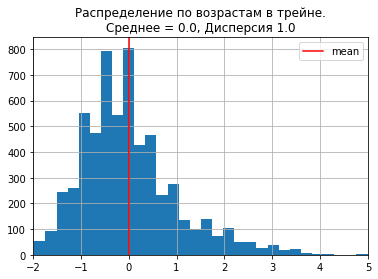

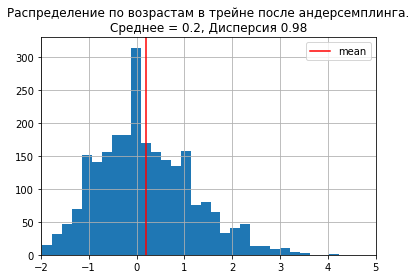

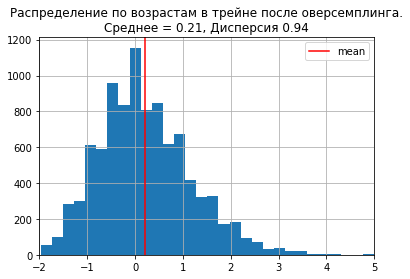

In [26]:
#print(features_train['age'].describe())
#print(features_train_under['age'].describe())
#print(features_train_over['age'].describe())

plt.hist(features_train['age'], bins=30)
mean = round(features_train['age'].mean(),2)
var = round(np.var(features_train['age']),2)
plt.axvline(features_train['age'].mean(), color='r', label = 'mean')
plt.legend()
plt.grid()
plt.xlim(-2,5)
plt.title(f'Распределение по возрастам в трейне.\nСреднее = {mean}, Дисперсия {var}')
plt.show()

plt.hist(features_down_train['age'], bins=30)
mean = round(features_down_train['age'].mean(), 2)
var = round(np.var(features_down_train['age']), 2)
plt.axvline(features_down_train['age'].mean(), color='r', label = 'mean')
plt.legend()
plt.grid(which='both')
plt.xlim(-2,5)
plt.title(f'Распределение по возрастам в трейне после андерсемплинга.\nСреднее = {mean}, Дисперсия {var}')
plt.show()

plt.hist(features_up_train['age'], bins=30)
mean = round(features_up_train['age'].mean(),2)
var = round(np.var(features_up_train['age']), 2)
plt.axvline(features_up_train['age'].mean(), color='r', label = 'mean')
plt.legend()
plt.grid(which='both')
plt.xlim(-2,5)
plt.title(f'Распределение по возрастам в трейне после оверсемплинга.\nСреднее = {mean}, Дисперсия {var}')
plt.show()

Да, масштабирование съехало. Не сильно. Если бы дисбаланс был больше, то и масштабирование, вероятно, сильнее испортилось. Наверное, грамотно будет заново промасштабировать все. Значит нужно делать отдельно валид- и тест- выборки перемаштабированные под каждый случай ресемплинга.

In [27]:
columns_to_scale = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']
scaler = StandardScaler()

scaler.fit(features_down_train[columns_to_scale])
features_down_valid = features_valid.copy()
features_down_test = features_test.copy()
features_down_train[columns_to_scale] = scaler.transform(features_down_train[columns_to_scale])
features_down_valid[columns_to_scale] = scaler.transform(features_valid[columns_to_scale])
features_down_test[columns_to_scale] = scaler.transform(features_test[columns_to_scale])

scaler.fit(features_up_train[columns_to_scale])
features_up_valid = features_valid.copy()
features_up_test = features_test.copy()
features_up_train[columns_to_scale] = scaler.transform(features_up_train[columns_to_scale])
features_up_valid[columns_to_scale] = scaler.transform(features_valid[columns_to_scale])
features_up_test[columns_to_scale] = scaler.transform(features_test[columns_to_scale])

### Логистическая регрессия

Сравним, какие метрики получаются при использовании гиперпараметра class_weight, а также upsampling и downsampling.
Пока посмотрим на автоматически подобранных параметрах.

In [28]:
#def f1()
model_LR_balanced = LogisticRegression(random_state=1, class_weight='balanced')
model_LR_balanced.fit(features_train, target_train)
predictions_valid = model_LR_balanced.predict(features_valid)
#print(model_LR_balanced.get_params())
print('f1 with class_weight:     ', f1_score(target_valid, predictions_valid))
probabilities_valid = model_LR_balanced.predict_proba(features_valid)
print('roc_auc with class_weight:', roc_auc_score(target_valid, probabilities_valid[:,1]))



model_LR = LogisticRegression(random_state=1)
model_LR.fit(features_up_train, target_up_train)
predictions_up_valid = model_LR.predict(features_up_valid)
#print(model_LR.get_params())
print('\nf1 with upsampling:       ', f1_score(target_valid, predictions_up_valid))
probabilities_up_valid = model_LR.predict_proba(features_up_valid)
print('roc_auc with upsampling:  ', roc_auc_score(target_valid, probabilities_up_valid[:,1]))


model_LR.fit(features_down_train, target_down_train)
predictions_down_valid = model_LR.predict(features_down_valid)
#print(model_LR.get_params())
print('\nf1 with downsampling:     ', f1_score(target_valid, predictions_down_valid))
probabilities_down_valid = model_LR.predict_proba(features_down_valid)
print('roc_auc with downsampling:', roc_auc_score(target_valid, probabilities_down_valid[:,1]))



f1 with class_weight:      0.5175438596491228
roc_auc with class_weight: 0.7818558157541208

f1 with upsampling:        0.4909420289855072
roc_auc with upsampling:   0.7767058275532852

f1 with downsampling:      0.5186500888099467
roc_auc with downsampling: 0.7820763752967143


Лучше всего получилось в случае с немодифицированной выборкой и парметром class_weight='balanced'. Поэтому стоит попробовать аккуратнее подобрать гиперпараметры модели в этом случае.

In [29]:
model_LR_balanced = LogisticRegression(random_state=1, class_weight='balanced', n_jobs=2)
param_LR = {
   'penalty'  : ['l1', 'l2', 'elasticnet', 'none'],
    'C'       : np.logspace(-1,1,10),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': range(80,140,10)
}

GS = GridSearchCV(model_LR_balanced,
                   param_grid=param_LR,
                   scoring='f1',
                   cv=5
)

GS.fit(features_train, target_train)

#print('best param', GS.best_params_)
predictions_valid = GS.predict(features_valid)
print('\nf1 from validation    :     ', f1_score(target_valid, predictions_valid))
probabilities_valid = GS.predict_proba(features_valid)
print('roc_auc from validation:', roc_auc_score(target_valid, probabilities_valid[:,1]))


f1 from validation    :      0.518843120070114
roc_auc from validation: 0.7818959174891379


Логистическая регрессия выдала максимум f1-score  0.52

### Дерево

Опять посмотрим, что лучше: class_weight='balanced', upsampling или downsampling

In [30]:
model_tree_balanced = DecisionTreeClassifier(random_state=1, class_weight='balanced')
model_tree_balanced.fit(features_train, target_train)
predictions_valid = model_tree_balanced.predict(features_valid)
#print(model_tree_balanced.get_params())
print('f1 with class_weight:     ', f1_score(target_valid, predictions_valid))
probabilities_valid = model_tree_balanced.predict_proba(features_valid)
print('roc_auc with class_weight:', roc_auc_score(target_valid, probabilities_valid[:,1]))


model_tree = DecisionTreeClassifier(random_state=1)
model_tree.fit(features_up_train, target_up_train)
predictions_up_valid = model_tree.predict(features_up_valid)
#print(model_tree.get_params())
print('\nf1 with upsampling:       ', f1_score(target_valid, predictions_up_valid))
probabilities_up_valid = model_tree.predict_proba(features_up_valid)
print('roc_auc with upsampling:  ', roc_auc_score(target_valid, probabilities_up_valid[:,1]))


model_tree.fit(features_down_train, target_down_train)
predictions_down_valid = model_tree.predict(features_down_valid)
#print(model_tree.get_params())
print('\nf1 with downsampling:     ', f1_score(target_valid, predictions_down_valid))
probabilities_down_valid = model_tree.predict_proba(features_down_valid)
print('roc_auc with downsampling:', roc_auc_score(target_valid, probabilities_down_valid[:,1]))

f1 with class_weight:      0.48635235732009924
roc_auc with class_weight: 0.6770699821547279

f1 with upsampling:        0.50989010989011
roc_auc with upsampling:   0.6999526491051915

f1 with downsampling:      0.4982758620689655
roc_auc with downsampling: 0.7093996924505399


Для дерева лучше всего оказался upsampling, f1-мера 0.51. Сделаем GridSearch и дадим ему upsampled выборку.

In [31]:
model_tree = DecisionTreeClassifier(random_state=1)

param_tree = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth': range(1, 15),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5),
}

GS_tree = GridSearchCV(model_tree,
                      param_grid=param_tree,
                      scoring='f1',
                      cv=5)

GS_tree.fit(features_up_train, target_up_train)
#print('best_score', GS_tree.best_score_)
#print('best params', GS_tree.best_params_)
predictions_up_valid = GS_tree.predict(features_up_valid)
print('\nf1 from validation:     ', f1_score(target_valid, predictions_up_valid))
probabilities_up_valid = GS_tree.predict_proba(features_up_valid)
print('roc_auc from validation:', roc_auc_score(target_valid, probabilities_up_valid[:,1]))


f1 from validation:      0.5313496280552603
roc_auc from validation: 0.7448473126439229


ГридСерч дотянул f1-метрику до 0.53 и auc_roc до 0.75 

### Лес

Выбираем, что лучше: class_weight='balanced', upsampling или downsampling

In [32]:
model_forest_balanced = RandomForestClassifier(random_state=1, class_weight='balanced')
model_forest_balanced.fit(features_train, target_train)
predictions_valid = model_forest_balanced.predict(features_valid)
#print(model_forest_balanced.get_params())
print('f1 with class_weight:     ', f1_score(target_valid, predictions_valid))
probabilities_valid = model_forest_balanced.predict_proba(features_valid)
print('roc_auc with class_weight:', roc_auc_score(target_valid, probabilities_valid[:,1]))


model_forest = RandomForestClassifier(random_state=1)
model_forest.fit(features_up_train, target_up_train)
predictions_up_valid = model_forest.predict(features_up_valid)
#print(model_forest.get_params())
print('\nf1 with upsampling:       ', f1_score(target_valid, predictions_up_valid))
probabilities_up_valid = model_forest.predict_proba(features_up_valid)
print('roc_auc with upsampling:  ', roc_auc_score(target_valid, probabilities_up_valid[:,1]))

model_forest.fit(features_down_train, target_down_train)
predictions_down_valid = model_forest.predict(features_down_valid)
#print(model_forest.get_params())
print('\nf1 with downsampling:     ', f1_score(target_valid, predictions_down_valid))
probabilities_down_valid = model_forest.predict_proba(features_down_valid)
print('roc_auc with downsampling:', roc_auc_score(target_valid, probabilities_down_valid[:,1]))

f1 with class_weight:      0.56793893129771
roc_auc with class_weight: 0.8345741735572245

f1 with upsampling:        0.5830164765525984
roc_auc with upsampling:   0.8372687016754814

f1 with downsampling:      0.5851272015655578
roc_auc with downsampling: 0.8376550664686256


Опять победил upsampling, f1-мера 0.58. Попробуем теперь рандомайзд серч и засунем в него upsampled выборку.

In [33]:
%%time
model_forest = RandomForestClassifier(random_state=1)
param_forest = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth': range(10, 20),
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(1, 3),
    'n_estimators': range(140, 160, 1)
}

GS_forest = RandomizedSearchCV(model_forest,
                        param_distributions = param_forest,
                        scoring='f1',
                        n_iter=100,
                        cv=5
)

GS_forest.fit(features_up_train, target_up_train)
#print('best_score', GS_forest.best_score_)
#print('best params', GS_forest.best_params_)
predictions_up_valid = GS_forest.predict(features_up_valid)
print('\nf1 from validation:     ', f1_score(target_valid, predictions_up_valid))
probabilities_up_valid = GS_forest.predict_proba(features_up_valid)
print('roc_auc from validation:', roc_auc_score(target_valid, probabilities_up_valid[:,1]))


f1 from validation:      0.5876543209876544
roc_auc from validation: 0.8421001895578166
CPU times: user 12min 19s, sys: 5.03 s, total: 12min 24s
Wall time: 12min 25s


In [34]:
print('best params', GS_forest.best_params_)

best params {'n_estimators': 151, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 18, 'criterion': 'entropy'}


f1=0.59, это самый хороший результат, поэтому выбираем модель леса как самую удачную.

### Вывод

Самой лучшей оказалась модель леса, f1 метрика 0.59, roc_auc = 0.84

## Финальное тестирование

А теперь возьмем наш обученный лес и протестируем его на тестовой выборке.

In [35]:
predictions_test = GS_forest.predict(features_up_test)
probabilities_test = GS_forest.predict_proba(features_up_test)
print ('f1-score', f1_score(target_test, predictions_test))
print('roc_auc ', roc_auc_score(target_test, probabilities_test[:,1]))

f1-score 0.5784061696658098
roc_auc  0.8397902502709627


## Выводы
- Учет несбалансированности классов позволяет повысить точность предсказания моделей
- В данной задаче самой эффективной моделью оказался случайный лес, натренированный на upsampled выборке
- Максимальная полученная f1-мера достигла 0.59 и roc_auc 0.84 на валидационной выборке и 0.58 и 0.84 на тестовой, соответственно. При тренировке модели без учета дисбаланса классов, f1-мера снижается до 0.57, а roc_auc практически не изменяется.